In [1]:
from matplotlib import pyplot as plt

from src.moglow import Moglow
from src.data import DigitsDataset

In [2]:
dataset = DigitsDataset()

In [3]:
num_channels, seq_len = dataset[0][0].shape
model = Moglow(
    num_channels=num_channels,
    seq_len=seq_len,
    levels=3,
    hidden_channels=10
)

In [4]:
from torch.utils.data import DataLoader

dl = DataLoader(dataset, batch_size=128, shuffle=True)

In [5]:
model.train(dataset, batch_size=128, max_epochs=100, log_interval=10)

 - Epoch  10: 367.236


[3.113829581420423,
 3.106179298396633,
 3.1001528154563163,
 3.093908684613244,
 3.0897277254625766,
 3.083389035980106,
 3.080645476836394,
 3.0770182835107125,
 3.070011162266973,
 3.067011370948108]

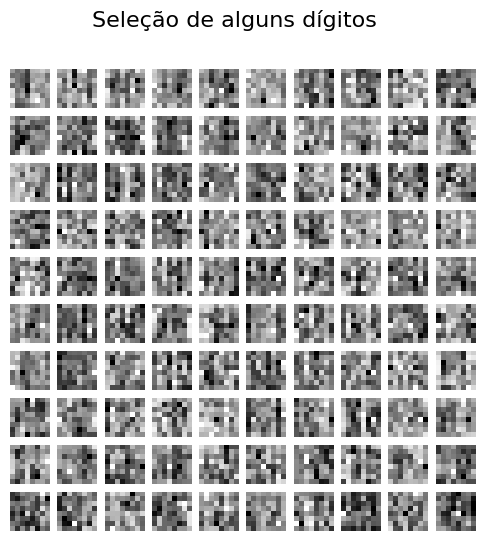

In [6]:
n_samples = 100
samples, log_prob = model.sample(n_samples)
images = samples[log_prob.argsort(), :].reshape(n_samples, num_channels, num_channels).cpu().detach().numpy()

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(images[idx, :, :], cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("Seleção de alguns dígitos", fontsize=16)